In [59]:
%load_ext autoreload
%autoreload 2 

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize
from scipy.signal import medfilt
from astropy import units as u
from tqdm import tqdm_notebook
from scipy.signal import find_peaks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
COLOR = 'white'

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

In [1]:
from pylab import *
colormap='viridis'

cmap = cm.get_cmap(colormap, 13)
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

colormap='inferno'
cmap = cm.get_cmap(colormap, 13)
acolors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    acolors.append(matplotlib.colors.rgb2hex(rgb))
acolors = np.array(acolors)

smallc = colors[1]
largec = colors[8]

smallca = acolors[5]
largeca = acolors[10]

In [2]:
smallca, largeca

('#9a2865', '#fbb61a')

In [3]:
%load_ext autoreload
%autoreload 2
import stella

In [4]:
data = np.load('final_set.npy', allow_pickle=True)
#CATALOG = Table.read('/Users/arcticfox/Documents/youngStars/final_southern_catalog.txt',
#                    format='ascii')

In [5]:
TICS = data[0]#[0:200]
TIME = data[1]#[0:200]
FLUX = data[2]#[0:200]
ERR = data[3]#[0:200]
PREDS = data[4]#[0:200]

## Identifies flares

In [6]:
ff = stella.FitFlares(TICS, TIME, FLUX,ERR, PREDS)

In [7]:
ff.identify_flare_peaks()

Finding & Fitting Flares:   1%|          | 32/3372 [00:00<02:22, 23.44it/s]/Users/arcticfox/Documents/GitHub/stella/stella/mark_flares.py:178: RuntimeWarning: divide by zero encountered in true_divide
  detrended = subf/func(subt)
//anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
Finding & Fitting Flares:   1%|▏         | 45/3372 [00:01<01:46, 31.35it/s]//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Finding & Fitting Flares:   9%|▉         | 316/3372 [00:10<01:53, 26.92it/s]/Users/arcticfox/Documents/GitHub/stella/stella/utils.py:36: RuntimeWarning: overflow encountered in exp
  return amp * np.exp( -(time - t0) / fall ) + flux
/Users/arcticfox/Documents/GitHub/stella/stella/mark_flares.py:118: RuntimeWarning: overflow encountere

## Maps phases

In [8]:
fts = stella.FindTheSpots(TICS, TIME, FLUX, ERR)
fts.run_LS()
fts.phase_lightcurve()

Finding most likely periods:  48%|████▊     | 1608/3372 [00:47<00:57, 30.43it/s]//anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
Getting Phases: 100%|██████████| 3372/3372 [00:53<00:00, 62.54it/s]


In [9]:
np.save('phases.npy', fts.phases)

In [10]:
bad = np.unique([67801852, 111835484, 99211241,140072113, 148158540, 169468632,
                 255134616, 259862349, 400445441, 129116176, 67801852, 111835484, 
                 99211241,140072113, 148158540, 169468632,
                 255134616, 259862349, 400445441])

## Looking at flares over entire light curve for each star

In [11]:
tot_time = np.zeros(len(fts.LS_results))
n_small = np.zeros(len(fts.LS_results))
n_large = np.zeros(len(fts.LS_results))

for i in range(len(fts.LS_results)):
    tic = fts.LS_results['Target_ID'].data[i]
    inds = np.where(TICS == tic)[0]
    tt = 0
    for n in inds:
        time = len(TIME[n]) * 2 * u.min
        time = time.to(u.day)
        tt += time.value
    tot_time[i] = tt
    flare_amps = ff.flare_table[ff.flare_table['Target_ID']==tic]['amp'].data
    n_small[i] = len(flare_amps[flare_amps < 1.05])
    n_large[i] = len(flare_amps[flare_amps >= 1.05])
fts.LS_results.add_column(Column(tot_time, 'total_observed_time'))
fts.LS_results.add_column(Column(n_small, 'Nflares_small'))
fts.LS_results.add_column(Column(n_large, 'Nflares_large'))

## Reads in table for ages

In [12]:
ages = Table.read('/Users/arcticfox/Documents/youngStars/ymg_catalog.txt',
                 format='ascii')

W0227 14:03:04.214341 4572960192 logger.py:204] OverflowError converting to FloatType in column YA_prob, possibly resulting in degraded precision.


In [13]:
ymg_age, ymg = np.zeros(len(fts.LS_results)), np.zeros(len(fts.LS_results), dtype='U10') 
teffs = np.zeros(len(fts.LS_results))
tmag = np.zeros(len(fts.LS_results))
for i in range(len(fts.LS_results['Target_ID'])):
    tic = fts.LS_results['Target_ID'].data[i]
    ind = np.where(ages['TIC']==tic)[0]
    if len(ind) >= 1:
        ymg_age[i] = ages['YA_age'].data[ind][0]
        ymg[i] = ages['Best_hyp'].data[ind][0]
        teffs[i] = ages['teff_val'].data[ind][0]
        tmag[i] = ages['Tmag'].data[ind][0]
        if ymg[i] == 'FIELD':
            ymg[i] = 'None'
            ymg_age[i] = 0
            teffs[i] = 0
    else:
        ymg_age[i] = 0
        ymg[i] = 'None'
        teffs[i] = 0

## Adds age columns

In [14]:
fts.LS_results.add_column(Column(ymg_age,'YMG_age'))
fts.LS_results.add_column(Column(ymg,'YMG'))
fts.LS_results.add_column(Column(teffs, 'teff_val'))
fts.LS_results.add_column(Column(tmag, 'Tmag'))

## Looks at flare distribution as a function of phase

In [15]:
peak_phase = np.array([])
peak_amp   = np.array([])

for i, tic in enumerate(fts.LS_results['Target_ID'].data):
    if fts.LS_results['flags'].data[i] == 1 and fts.LS_results['Tmag'].data[i] < 16:
        flares = ff.flare_table[ff.flare_table['Target_ID']==tic]
        peaks  = flares['tpeak'].data
        amps   = flares['amp'].data
        for a, p in zip(amps, peaks):
            ti = np.where(fts.time[i] == p)[0]
            if len(ti) > 0 and np.nanmedian(fts.phases[i]) != 0:
                peak_phase = np.append(peak_phase, fts.phases[i][ti])
                peak_amp   = np.append(peak_amp, a)

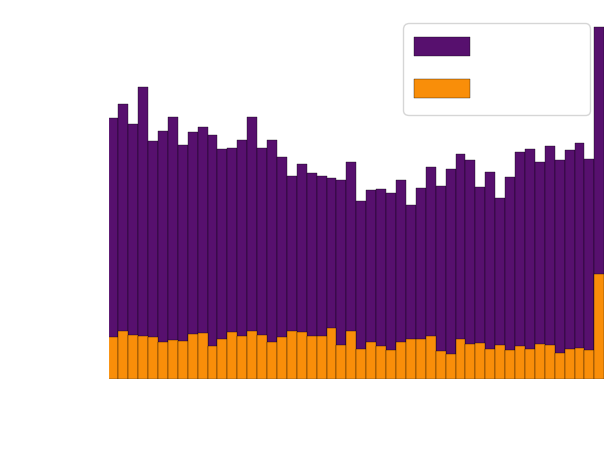

In [76]:
small = np.where((peak_amp<1.05))# & (peak_amp>=1.01))
vsmall = np.where(peak_amp<1.005)
big = np.where(peak_amp >= 1.05)


plt.hist(peak_phase[small], bins=np.arange(-0.6,0.6,0.02), color=acolors[3],
        label='< 5%', edgecolor='k', linewidth=0.25)
plt.hist(peak_phase[big], bins=np.arange(-0.6,0.6,0.02), color=acolors[9],
        label='$\geq$ 5%', edgecolor='k', linewidth=0.25)
#plt.yticks([10,100,200])
plt.xlim(-0.5,0.5)
plt.legend()
plt.facecolor = False
plt.xlabel('Phase')
plt.ylabel('$N_{flares}$')
plt.savefig('/Users/arcticfox/Desktop/phase.png', dpi=250, rasterize=True,
           bbox_inches='tight', transparent=True)

## Histogram plotting function

In [160]:
def histogram(phase, amps, counts, weights, titles, megatitle, save=False, path=None):
    plt.rcParams['font.size'] = 18
    track_lims = []
    fig, axes = plt.subplots(ncols=int(len(titles)/2), 
                             nrows=2, figsize=(14,8),
                             sharex=True, sharey=True)
    z = 0
    # Divide by summed total number of days observed for each bin

    #if 'Myr' in titles[0]:
    color1 = smallca 
    color2 = largeca
    #else:
    #    color1 = smallc
    #    color2 = largec
    
    bins = np.arange(0,1.01,0.01)

    
    for ax in axes.reshape(-1):
        peak_amp = amps[z] - 1
        peak_phase = phase[z]

        small = np.where((peak_amp<0.05))[0]
        big = np.where(peak_amp >= 0.05)[0]


        if z == 4:
            ax.set_xlabel('Flare Amplitude [%]', fontsize=22)
        if z == 3:
            ax.set_ylabel('Flares/Day/Star', y=1.01, fontsize=22)

        ax.hist(peak_amp[small], bins=bins, color=color2,
                edgecolor='black', linewidth=0.25, weights=weights[z][small]/counts[z])
        ax.hist(peak_amp[big], bins=bins, color=color2,
                edgecolor='black', linewidth=0.25, weights=weights[z][big]/counts[z])
        
        ax.set_xlim(0, 1.0)
        ax.set_xticks(np.arange(0,1.25,0.25))
        ax.set_xticklabels(np.arange(0,125,25))
     #   ax.set_xticklabels(labels=[-0.5, -0.25, 0, 0.25, 0.5],
     #                       fontsize=16)

        track_lims.append(ax.get_ylim()[-1])
        ax.set_yscale('log')
        ax.set_title('{}'.format(titles[z]),
                 y = 0.85, fontweight='bold')

        z += 1

    axes.reshape(-1)[1].text(0.25, np.nanmax(track_lims),
                             megatitle,
                             fontsize=26, fontweight='bold',
                             ha='center')
    
    plt.subplots_adjust()
    if save:
        fig.savefig(path, dpi=300, rasterize=True, bbox_inches='tight')
    else:
        return fig

## Bins by Age

In [18]:
AGE_RANGE = np.array([0,10,20,40,60,140,160,560,580])

In [19]:
def age_bins(table, flare_table, time, lc_phases):
    phase, amps, temps = [], [], []
    counts, titles = [], []
    weights = []

    for r in range(len(AGE_RANGE)-1):
        group = np.where( (table['YMG_age'].data >= AGE_RANGE[r]) & 
                          (table['YMG_age'].data <= AGE_RANGE[r+1]))[0]

        pp, pa, tw, teffs = np.array([]), np.array([]), np.array([]), np.array([])
        t = 0

        if AGE_RANGE[r] != 160 and AGE_RANGE[r+1] != 560 and len(group) > 0:
            for c, tic in enumerate(table['Target_ID'].data[group]):
                if table['Tmag'].data[group[c]] < 15 and table['flags'].data[group[c]] == 1:
                    flares = flare_table[flare_table['Target_ID'] == tic]
                    peaks  = flares['tpeak'].data
                    tamps  = flares['amp'].data

                    tk     = table[table['Target_ID']==tic]['teff_val'].data

                    inds   = np.where(table['Target_ID'] == tic)[0]
                    tt     = np.nanmedian(table['total_observed_time'].data[inds])
                    for i in inds:
                        for x in range(len(tamps)):
                            a = tamps[x]
                            p = peaks[x]
                            ti = np.where(time[i] == p)[0]
                            if len(ti) > 0 and np.nanmedian(lc_phases[i]) != 0:
                                pp = np.append(pp, lc_phases[i][ti])
                                pa = np.append(pa, a)
                                tw = np.append(tw, 1/tt)
                                teffs  = np.append(teffs, np.nanmean(tk))

                t += 1
            phase.append(pp)
            amps.append(pa)
            counts.append(t)
            weights.append(tw)
            temps.append(teffs)
            titles.append('{}-{} Myr'.format(AGE_RANGE[r], AGE_RANGE[r+1]))
            
    return phase, amps, counts, weights, titles, temps

In [20]:
aphase, aamps, acounts, aweights, atitles, atemps = age_bins(fts.LS_results,
                                                             ff.flare_table,
                                                             fts.time,
                                                             fts.phases)

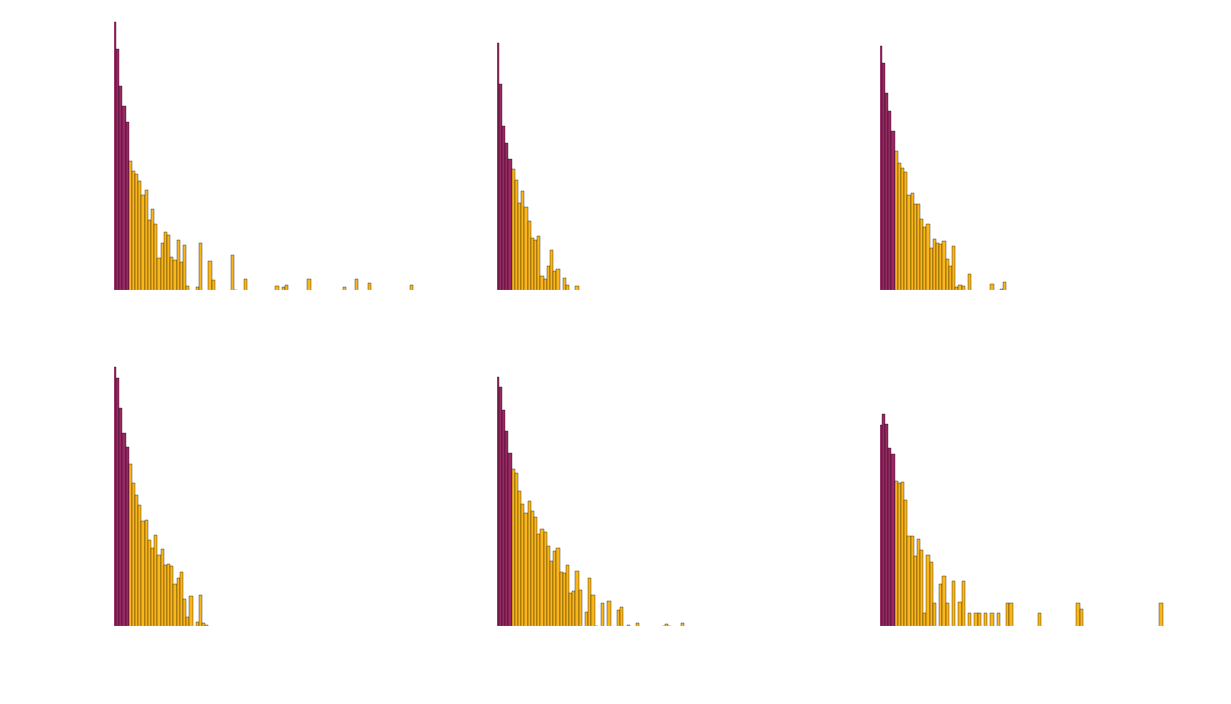

In [85]:
fig = histogram(aphase, aamps, acounts, aweights, atitles, '')

In [86]:
fig.savefig('/Users/arcticfox/Desktop/perAge.png', dpi=250, rasterize=True,
           bbox_inches='tight', transparent=True)

## Bins flares as a function of temperature

In [22]:
TEMP_RANGE = np.array([3000, 3500, 4000, 4500, 5000, 6200, 11000])

In [23]:
def temp_bins(table, flare_table, time, lc_phases):
    global TEMP_RANGE
    
    phase = []
    amps  = []
    weights = []
    titles = []
    counts = []
    ages = []
    
    for r in range(len(TEMP_RANGE)-1):
        group = np.where((table['teff_val'].data>=TEMP_RANGE[r]) & 
                         (table['teff_val'].data<TEMP_RANGE[r+1]) & 
                         (table['teff_val'].data != 0.0))[0]

        pp = np.array([])
        pa = np.array([])
        tw = np.array([])
        ymgage = np.array([])
        t = 0
        if len(group) > 0:
            for tic in table['Target_ID'].data[group]:
                flares = flare_table[ff.flare_table['Target_ID']==tic]
                peaks  = flares['tpeak'].data
                tamps   = flares['amp'].data
                ya     = table[table['Target_ID']==tic]['YMG_age'].data
  
                inds = np.where(table['Target_ID'] == tic)[0]
                tt   = np.nanmedian(table['total_observed_time'].data[inds])
                
                for i in inds:
                    for x in range(len(tamps)):
                        a = tamps[x]
                        p = peaks[x]
                        ti = np.where(time[i] == p)[0]
                        if len(ti) > 0 and np.nanmedian(lc_phases[i]) != 0:
                            pp = np.append(pp, lc_phases[i][ti])
                            pa   = np.append(pa, a)
                            tw = np.append(tw, 1/tt)
                            ymgage = np.append(ymgage, np.nanmean(ya))
                t += 1
        phase.append(pp)
        amps.append(pa)
        weights.append(tw)
        titles.append('{}-{} K'.format(TEMP_RANGE[r], TEMP_RANGE[r+1]))
        counts.append(t)
        ages.append(ymgage)
    return phase, amps, counts, weights, titles, ages

In [24]:
tphase, tamps, tcounts, tweights, ttitles, tages = temp_bins(fts.LS_results,
                                                             ff.flare_table,
                                                             fts.time,
                                                             fts.phases)

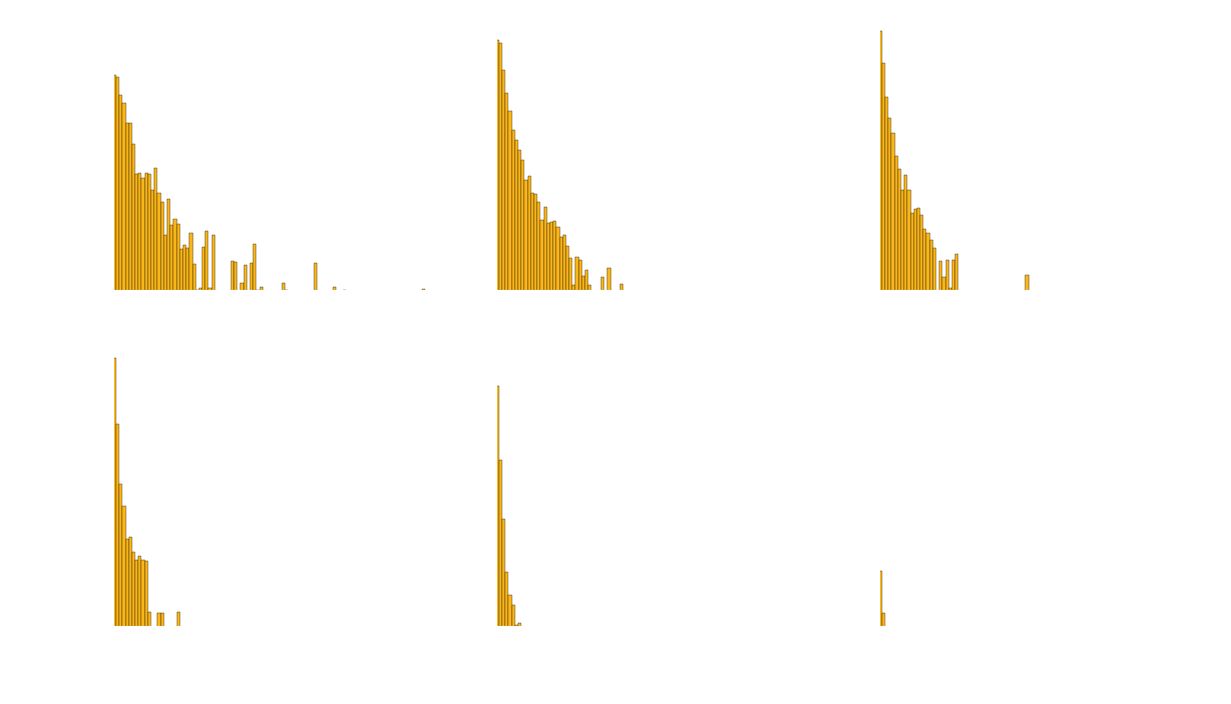

In [161]:
fig = histogram(tphase, tamps, tcounts, tweights, ttitles, '')

In [162]:
fig.savefig('/Users/arcticfox/Desktop/perTemp.png', dpi=250, rasterize=True,
           bbox_inches='tight', transparent=True)

## Rotation & Flare count

In [26]:
maxflare = np.zeros(len(fts.LS_results))
    
for i, tic in enumerate(fts.LS_results['Target_ID']):
    flares = np.where(ff.flare_table['Target_ID'] == float(tic))[0]
    try:
        maxflare[i] = np.nanmax(ff.flare_table['amp'].data[flares])
    except:
        pass

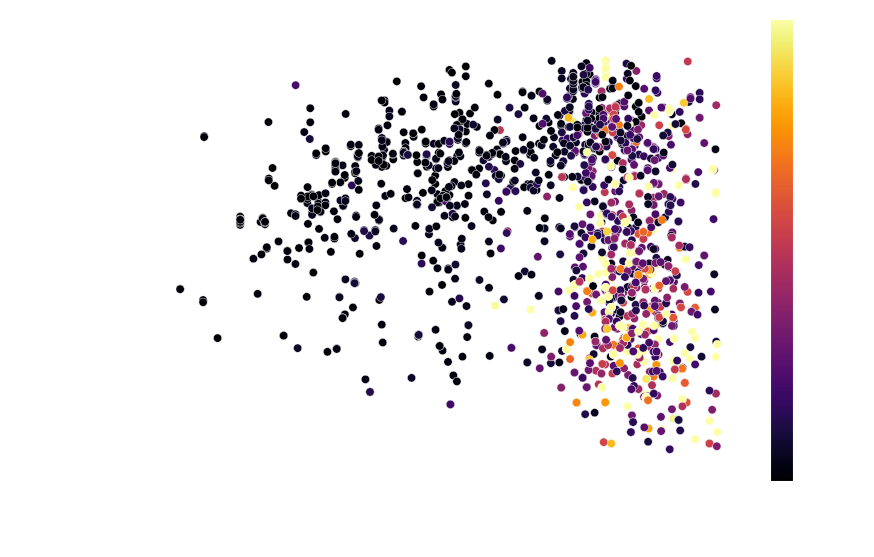

In [120]:
fig, ax = plt.subplots(figsize=(10,6))
q =( (maxflare != 0.0 )&( fts.LS_results['flags'] == 1))
plt.scatter(fts.LS_results['teff_val'][q],
            fts.LS_results['avg_period_days'][q],
            c=maxflare[q]-1, vmin=0, vmax=0.5,
            cmap='inferno', edgecolor=COLOR, linewidth=0.3)
cbar = plt.colorbar(label='Maximum Flare Amplitude [%]')
cbar.ax.set_yticklabels(np.arange(0,60,10))
plt.xlim(7000,3200)
plt.ylim(0.1,18)
plt.yscale('log')
plt.xlabel('$T_{eff}$ [K]')
plt.ylabel('$P_{rot}$ [Days]')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')

plt.savefig('/Users/arcticfox/Desktop/rotation_maxflare.png', dpi=300,
            rasterize=True, bbox_inches='tight', transparent=True)

## Add in non-Prot measured stars

## Bin by both?

In [28]:
temp_lines = np.zeros((len(TEMP_RANGE)-1,6))

for temp in range(len(TEMP_RANGE)-1):
    r = 0
    for age in range(len(AGE_RANGE)-1):
        if ((AGE_RANGE[age] == 60 and AGE_RANGE[age+1] == 140) or 
            (AGE_RANGE[age] == 160 and AGE_RANGE[age+1] == 560)):
            continue
        else:
            ind = np.where((fts.LS_results['YMG_age'] >= AGE_RANGE[age]) &
                           (fts.LS_results['YMG_age'] <  AGE_RANGE[age+1]) &
                           (fts.LS_results['teff_val'] >=  TEMP_RANGE[temp]) & 
                           (fts.LS_results['teff_val'] <  TEMP_RANGE[temp+1]))[0]
           # print(AGE_RANGE[age], TEMP_RANGE[temp], len(ind))
            if len(ind) > 0:
                nflares = 0
                ttime   = 0 
                for i in ind:
                    nflares += fts.LS_results['Nflares_large'].data[i]
                    nflares += fts.LS_results['Nflares_small'].data[i]
                    ttime += fts.LS_results['total_observed_time'].data[i]
                temp_lines[temp][r] = nflares/ttime#len(np.unique(fts.LS_results['Target_ID'].data[ind]))

            else:
                temp_lines[temp][r] = 0.0
            r += 1
            
    plt.show()

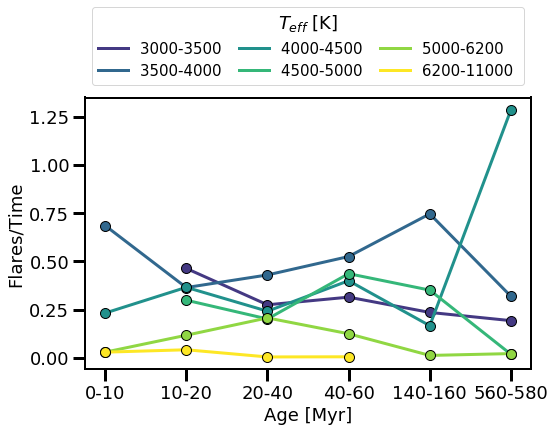

In [29]:
fig, ax = plt.subplots(figsize=(8,5))

for i in range(len(temp_lines)):
    q = temp_lines[i] != 0
    plt.plot(np.arange(0,len(temp_lines[i]),1)[q],
             temp_lines[i][q], c=colors[(i+1)*2], linewidth=3,
             label=ttitles[i][:-1])
    plt.plot(np.arange(0,len(temp_lines[i]),1)[q],
             temp_lines[i][q], 'o', c=colors[(i+1)*2],
             markeredgecolor='k', ms=10)
#plt.yscale('log')
ax.set_facecolor('white')
plt.ylabel('Flares/Time')
plt.xlabel('Age [Myr]')
plt.xticks([0, 1, 2, 3, 4, 5],
           labels=['0-10', '10-20', '20-40', '40-60', 
                   '140-160', '560-580'])
plt.legend(ncol=3, bbox_to_anchor=(0., 1.02, 1., .102),
           loc='lower left', fontsize='small',
           mode='expand', title='$T_{eff}$ [K]')
plt.show()

## Stacked histograms

In [121]:
def stacked_histogram_temps(phase, amps, counts, weights, titles, temps, keyword='small', 
                            save=False, path=None):
    plt.rcParams['font.size'] = 18
    track_lims = []
    fig, axes = plt.subplots(ncols=int(len(titles)/2), 
                             nrows=2, figsize=(14,8),
                             sharex=True, sharey=True)
    z = 0
    # Divide by summed total number of days observed for each bin

    color1 = smallca 
    color2 = largeca

    bins = np.arange(1.0, 1.5, 0.01)
    
    for ax in axes.reshape(-1):
        peak_amp = amps[z]
        peak_phase = phase[z]
        temp = temps[z]

        small = np.where((peak_amp<1.05) & (temp<=4000))[0]
        big = np.where( (temp<=4000))[0]
        
        small_hot = np.where((peak_amp<1.05) & (temp>4000))[0]
        big_hot = np.where( (temp>4000))[0]


        if z == 4:
            ax.set_xlabel('Flare Amplitude', fontsize=22)
        if z == 3:
            ax.set_ylabel('Flares/Day/Star', y=1.01, fontsize=22)

        if keyword is 'small':
            ax.hist([peak_phase[small], peak_phase[small_hot]], 
                    bins=np.arange(-0.6,0.6,0.05), color=[color1,color2],
                    edgecolor='black', linewidth=0.25, 
                    weights=[weights[z][small]/counts[z], weights[z][small_hot]/counts[z]],
                    stacked=True, histtype='bar', label=['$\leq$ 4000', '> 4000'])
        elif keyword is 'large':
            ax.hist(peak_amp[big], 
                                bins=bins, color=color1,
                                edgecolor='black', linewidth=0.25, 
                                weights=weights[z][big]/counts[z],
                                histtype='bar', label='$\leq$ 4000', alpha=0.8)
            ax.hist(peak_amp[big_hot],
                                bins=bins, color=color2,
                                edgecolor='black', linewidth=0.25, 
                                weights=weights[z][big_hot]/counts[z],
                                histtype='bar', label='> 4000', alpha=0.4)

        if z == 1:
            ax.legend(ncol=2, bbox_to_anchor=(0., 1.02, 1., .102),
                      loc='lower left', mode='expand', title='$T_{eff}$ [K]',
                      fontsize='small')
            
        ax.set_xlim(1.0, 1.2)
   #     ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5]) 
   #     ax.set_xticklabels(labels=[-0.5, -0.25, 0, 0.25, 0.5],
   #                         fontsize=16)

        track_lims.append(ax.get_ylim()[-1])

        ax.set_title('{}'.format(titles[z]),
                 y = 0.85, fontweight='bold')

        z += 1

#    axes.reshape(-1)[1].text(-0.05, np.nanmax(track_lims)+0.0013,
#                             megatitle,
#                             fontsize=26, fontweight='bold',
#                             ha='center')
    
    plt.subplots_adjust()
    if save:
        fig.savefig(path, dpi=300, rasterize=True, bbox_inches='tight')
    else:
        return fig

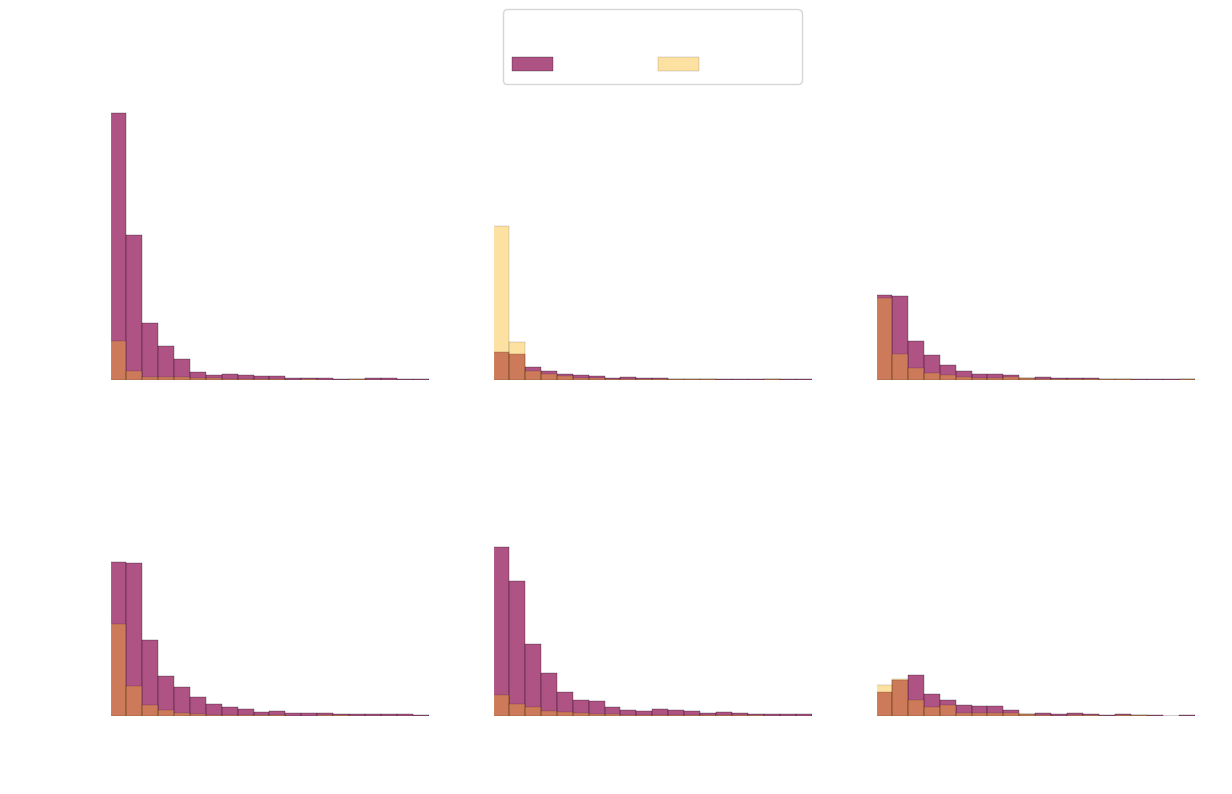

In [122]:
fig = stacked_histogram_temps(aphase, aamps, acounts, aweights, 
                              atitles, atemps, keyword='large')

In [197]:
def stacked_histogram_ages(phase, amps, counts, weights, titles, ages, keyword='small', 
                      save=False, path=None):
    plt.rcParams['font.size'] = 18
    track_lims = []
    fig, axes = plt.subplots(ncols=int(len(titles)/2), 
                             nrows=2, figsize=(14,8),
                             sharex=True, sharey=True)
    z = 0
    # Divide by summed total number of days observed for each bin

    color1 = smallca 
    color2 = largeca

    bins = np.arange(1.0,1.5,0.01)
    
    for ax in axes.reshape(-1):
        peak_amp = amps[z]
        peak_phase = phase[z]
        age = ages[z]

        small = np.where((peak_amp<1.05) & (age<=50) & (age>0))[0]
        big = np.where( (age<=50) & (age>0))[0]
        
        small_hot = np.where( (age>50))[0]
        big_hot = np.where( (age>50))[0]
        
        all_old = np.where(age > 50)[0]
        all_young = np.where(age <= 50)[0]


        if z == 4:
            ax.set_xlabel('Flare Amplitude [%]', fontsize=22)
        if z == 3:
            ax.set_ylabel('Flares/Day/Star', y=1.01, fontsize=22)

        if keyword is 'small':
            ax.hist(peak_amp[small], 
                                bins=bins, color=color1,
                                edgecolor='black', linewidth=0.25, 
                                weights=weights[z][small]/counts[z],
                                histtype='bar', label='$\leq$ 50')
            ax.hist(peak_amp[small_hot],
                                bins=bins, color=color2,
                                edgecolor='black', linewidth=0.25, 
                                weights=weights[z][small_hot]/counts[z],
                                histtype='bar', label='> 50')
        elif keyword is 'large':
            ax.hist(peak_amp[big], 
                                bins=bins, color=color1,
                                edgecolor='black', linewidth=0.25, 
                                weights=weights[z][big]/counts[z],
                                histtype='bar', label='$\leq$ 50')
            ax.hist(peak_amp[big_hot],
                                bins=bins, color=color2,
                                edgecolor='black', linewidth=0.25, 
                                weights=weights[z][big_hot]/counts[z],
                                histtype='bar', label='> 50')
        elif keyword is 'all':
            ax.hist(peak_amp[all_young], 
                                bins=bins, color=color1,
                                edgecolor='black', linewidth=0.25, 
                                weights=weights[z][all_young]/counts[z],
                                histtype='bar', label='$\leq$ 50')
            ax.hist(peak_amp[all_old],
                                bins=bins, color=color2,
                                edgecolor='black', linewidth=0.25, 
                                weights=weights[z][all_old]/counts[z],
                                histtype='bar', label='> 50')
            
        if z == 2:
            ax.legend(fontsize=18, title='Age [Myr]',
                      bbox_to_anchor=(1, -0.35, 0.65, 0.0),
                      loc='lower right', mode='expand')
            
        ax.set_xlim(1.0, 1.2)
    #    ax.set_xticks(np.arange(1,2.25,0.25))
        ax.set_xticklabels(np.arange(0,125,25))

        track_lims.append(ax.get_ylim()[-1])

        ax.set_title('{}'.format(titles[z]),
                 y = 0.85, fontweight='bold')

        z += 1

    
    plt.subplots_adjust()
    if save:
        fig.savefig(path, dpi=300, rasterize=True, bbox_inches='tight')
    else:
        return fig

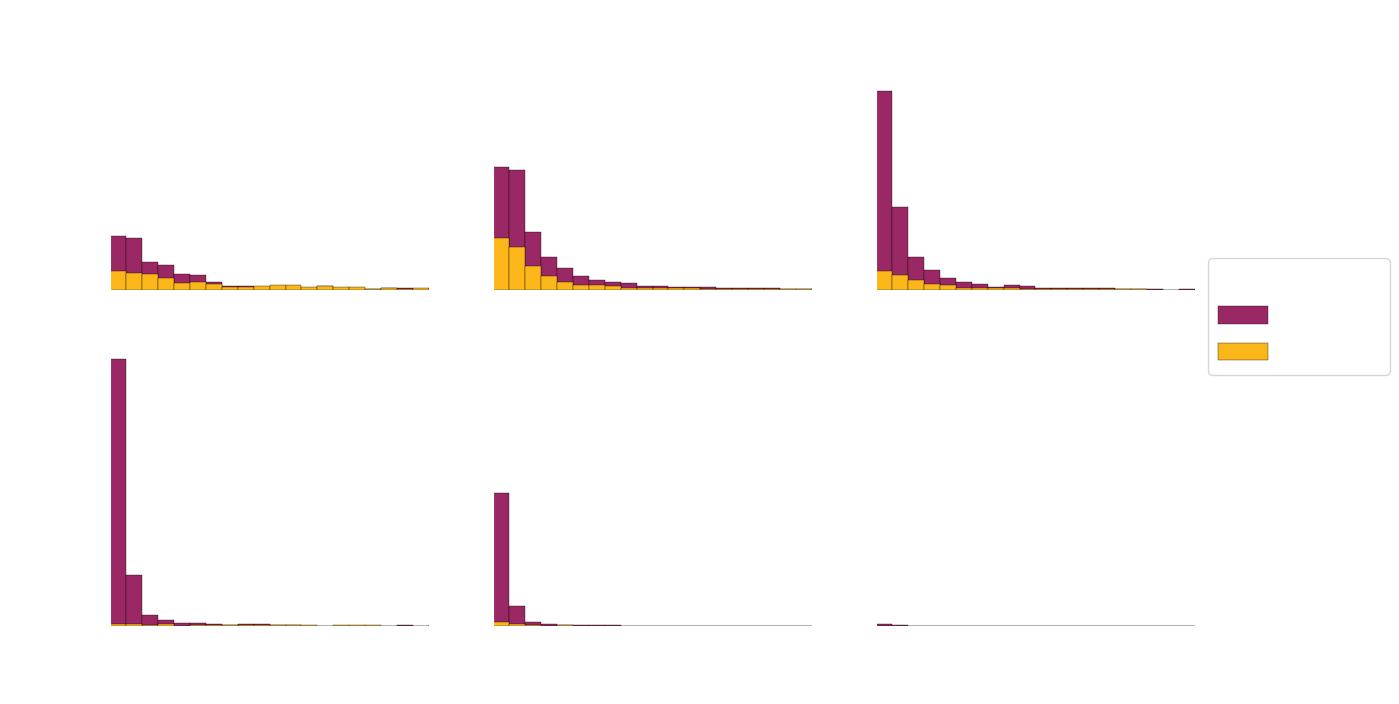

In [199]:
fig = stacked_histogram_ages(tphase, tamps, 
                             tcounts, tweights, 
                             ttitles, tages, keyword='all')
fig.savefig('/Users/arcticfox/Desktop/byage.png', dpi=250, rasterize=True,
           bbox_inches='tight', transparent=True)